In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.applications import VGG16
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt


In [6]:
path = "..\\Dataset"

breast_category = {
    'benign':0 , 'malignant':1, 'normal' :2
}

train_category = []
filenames = []

for breast in breast_category.keys():
    breast_path = os.path.join(path, breast)
    for i in os.listdir(breast_path):
        full_path = os.path.join(breast_path, i)
        filenames.append(full_path)
        train_category.append(breast_category[breast])

df = pd.DataFrame({'filename': filenames, 'category': train_category})
df_train , df_validate = train_test_split(df, test_size = 0.2, random_state=42)

In [7]:
df_train['category'] = df_train['category'].astype(str)
train_data_generation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_data_generation.flow_from_dataframe(
    dataframe=df_train,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True)

df_validate['category'] = df_validate['category'].astype(str)
validate_data_generation = ImageDataGenerator(
    rescale=1./255,

)

validate_generator = validate_data_generation.flow_from_dataframe(
    dataframe=df_validate,
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 1262 validated image filenames belonging to 3 classes.
Found 316 validated image filenames belonging to 3 classes.


In [18]:


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers, for example
    layer.trainable = True


# Build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

In [19]:

reduceLR= ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks = [reduceLR, early]
model.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics = ["accuracy"])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,141,955 (57.76 MB)

 Trainable params: 7,506,691 (28.64 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [20]:
history = model.fit(
train_generator,
epochs=40,
validation_data=validate_generator,
callbacks = callbacks)


Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 660ms/step - accuracy: 0.4954 - loss: 1.0342 - val_accuracy: 0.6044 - val_loss: 0.6772 - learning_rate: 0.0010
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 491ms/step - accuracy: 0.5558 - loss: 0.7968 - val_accuracy: 0.8513 - val_loss: 0.4467 - learning_rate: 0.0010
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 517ms/step - accuracy: 0.7507 - loss: 0.6329 - val_accuracy: 0.8797 - val_loss: 0.3817 - learning_rate: 0.0010
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 494ms/step - accuracy: 0.8021 - loss: 0.5115 - val_accuracy: 0.8797 - val_loss: 0.3100 - learning_rate: 0.0010
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 512ms/step - accuracy: 0.8301 - loss: 0.4370 - val_accuracy: 0.8829 - val_loss: 0.2904 - learning_rate: 0.0010
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 505ms/step - accuracy: 0.8347 - loss: 0.4307 - val_accuracy: 0.8987 - val_loss: 0.2756 - learning_rate: 0.0010
Epoch 7/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 490ms/step - accuracy: 0.8577 - loss: 0.

In [21]:
model.save("..\\models\\model.h5")

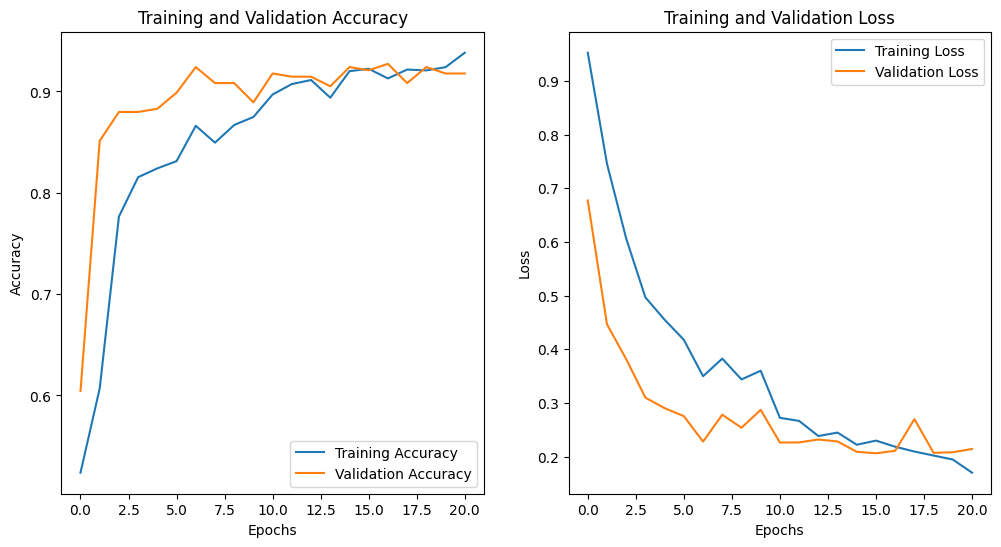

In [22]:

# Extract accuracy and loss data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
